In [8]:
import util.preprocess.SampleMask as SampleMask
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import tensorflow as tf
import torch

In [2]:
#from models.DeepFoveaRNN import DeepFoveaModel

# Callbacks, Generators, and Helpers
from util.callbacks.ImageGeneratorPredictionCallback import ImageGeneratorPredictionCallback
from util.imggen_helpers import getResourceList, getImages
from util.generators.MaskSequenceBatchGenerator import MaskSequenceBatchGenerator

#Losses
from util.losses.vgg import vgg_loss
from util.losses.mixed import make_mixed_loss

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import albumentations as A

import os
import datetime
from util.dataloaders.ImageDataLoader import ImageDataLoader
import random
import sys
import cv2

In [3]:
# Based on "DeepFovea: Neural Reconstruction for Foveated Rendering and Video Compression using Learned Natural Video Statistics"
class DeepFoveaModel:

    def __init__(self, input1, output_shape=None, batch_size=5):
        
        self.batch_size = batch_size
        
        if output_shape == None:
            output_shape = tf.shape(input_shape)
            

        #Create residual blocks
        res1 = self.res_block(32,   3, input1)
        res2 = self.res_block(64,  3, res1)
        res3 = self.res_block(128,  3, res2)
        res4 = self.res_block(128,  3, res3)
        res5 = self.res_block(128, 3, res4)

        #Create temporal blocks
        tmp1 = self.temp_block(128, 3, res5, skip=None)
        tmp2 = self.temp_block(128, 3, tmp1, skip=res4)
        tmp3 = self.temp_block(64, 3, tmp2, skip=res3)
        tmp4 = self.temp_block(32, 3, tmp3, skip=res2)
        tmp5 = self.temp_block(output_shape[2], 3, tmp4, skip=res1, recurrent=False)
                
        # Create and compile model
        self.model = keras.Model(input1, tmp5)

    def get_model(self):
        return self.model

    def plot_model(self):
        keras.utils.plot_model(self.model)

    def res_block(self, output_size, kernel_size, inputs):
        # Convolute
        conv1 = layers.Conv2D(output_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = layers.Conv2D(output_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

        # Combine
        conv3 = layers.Conv2D(output_size, 1)(inputs)
        add1 = layers.Add()([conv2, conv3])

        # Downscale
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(add1)

        return pool1

    def temp_block(self, output_size, kernel_size, inputs, skip=None, recurrent=True):
        
        if skip is not None:
            # Establish skip connection
            skip1 = layers.Add()([inputs, skip])
        else:
            skip1 = inputs
        
        if recurrent:
            # Recurrent
            rec1 = OnePassRecurrent(output_size, kernel_size, self.batch_size)(skip1)
            conv2 = layers.Conv2D(output_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(rec1)
        else:
            # Convolute
            conv1 = layers.Conv2D(output_size, kernel_size, padding = 'same', kernel_initializer = 'he_normal')(skip1) # Notice no activation. Added after layer norm
            norm1 = layers.LayerNormalization()(conv1)
            relu1 = layers.ReLU()(norm1)
            conv2 = layers.Conv2D(output_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(relu1)
            

        # Combine
        conv3 = layers.Conv2D(output_size, 1)(inputs)
        add1 = layers.Add()([conv2, conv3])

        # Upscale
        up1 = layers.UpSampling2D(interpolation='bilinear')(add1)
        return up1


class OnePassRecurrent(keras.layers.Layer):
    
    def __init__(self, output_size, kernel_size, batch_size, **kwargs):
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.batch_size = batch_size
        super(OnePassRecurrent, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.conv1 = layers.Conv2D(self.output_size, self.kernel_size, padding = 'same', kernel_initializer = 'he_normal') # Notice no activation. Added after layer norm
        self.norm1 = layers.LayerNormalization()
        self.relu1 = layers.ReLU()
        
        output_shape = input_shape.as_list()
        output_shape[-1] = self.output_size
        output_shape[0] = self.batch_size
        self.last_output = tf.Variable(tf.zeros(output_shape), trainable=False)
        
        
        # TODO This does not work right now
        #self.last_output = tf.Variable(tf.fill(input_shape, 0.0), validate_shape=False, trainable=False)
        #self.last_output = tf.Variable(tf.fill(tf.TensorShape(input_shape), 0.0))
                
    def call(self, inputs):
        lastx = self.last_output
        x = layers.Concatenate()([inputs, lastx])
        x = inputs
            
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        
        tf.keras.backend.update(self.last_output, x)
        
        return x
    
    def get_config(self):
        return {
            'output_size': self.output_size, 
            'kernel_size': self.kernel_size, 
            'batch_size': self.batch_size
        }

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.executing_eagerly()

True

In [5]:
# Define the Loss
a = 0.0
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
loss = make_mixed_loss(mae, vgg_loss, a)
loss_name = f'{a}L1-{1-a}VGG'

In [6]:
# Open the strategy scope and do creationg & compiling of the model within that scope
#with strategy.scope():
input1 = layers.Input(shape=input_shape)
dmodel = DeepFoveaModel(input1=input1, output_shape=output_shape, batch_size=batch_size)
model = dmodel.get_model()

opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt, loss=loss, metrics=[loss])

NameError: name 'input_shape' is not defined

In [9]:
sponza = img.imread('./data/sponza.jpg')
plt.imshow(sponza)
plt.show()

seq = SampleMask.GetSampleMaskSequence((1080,1920), int(1920*0.1))
for i in range(seq.shape[0]):
    idx = (seq[i,:,:] == 0)
    sp = np.array(sponza)
    print(sp.shape)
    sp[idx] = 0
    plt.imshow(sp, interpolation='None')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './data/sponza.jpg'

In [3]:
imported = tf.saved_model.load('./')

OSError: Cannot parse file b'./saved_model.pb': Error parsing message.

### Test Albumentations

In [5]:
shape = (128,128)
batches = 2
image_set = '1616987110958'
image_data_loader = ImageDataLoader(image_set, 512, shape, batches, 10)

Loading Masks
Loading dir /home/davbauer/Projects/FoVolNet/util/preprocess/../../data/noise_textures/16
Loading dir /home/davbauer/Projects/FoVolNet/util/preprocess/../../data/noise_textures/128
Loading dir /home/davbauer/Projects/FoVolNet/util/preprocess/../../data/noise_textures/32
Loading dir /home/davbauer/Projects/FoVolNet/util/preprocess/../../data/noise_textures/64
Loading dir /home/davbauer/Projects/FoVolNet/util/preprocess/../../data/noise_textures/256


In [6]:
batch = image_data_loader.next_train()[0]

In [7]:
batch.shape

torch.Size([2, 10, 7, 128, 128])

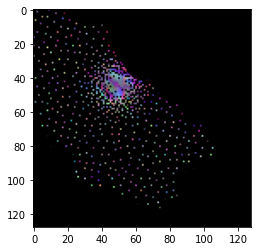

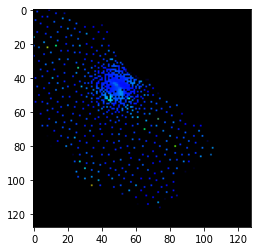

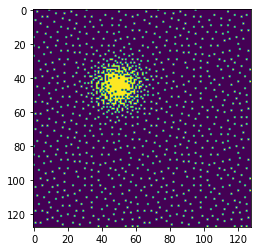

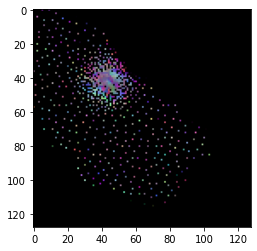

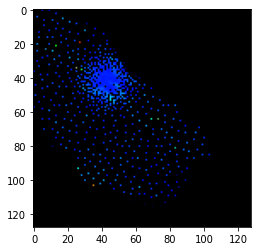

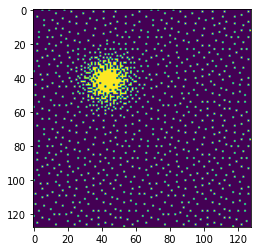

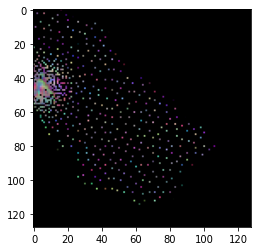

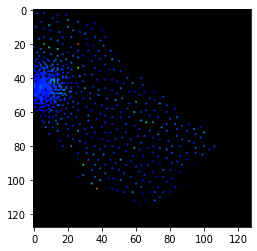

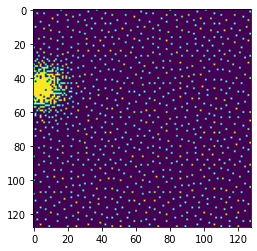

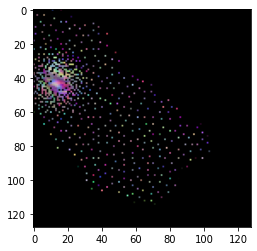

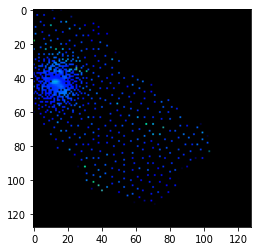

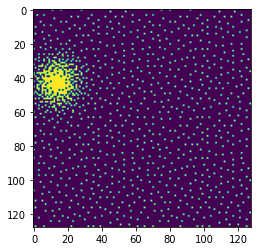

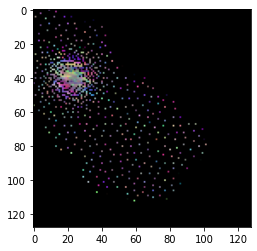

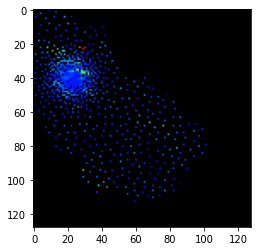

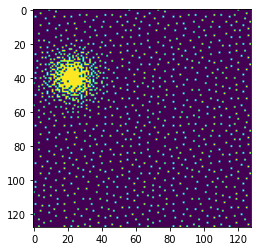

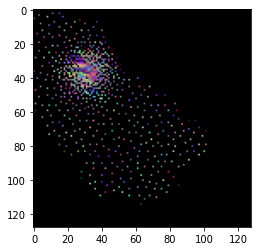

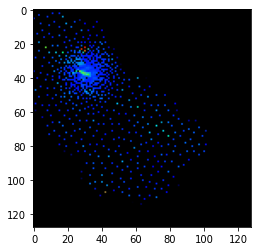

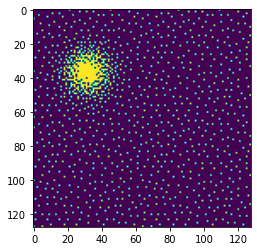

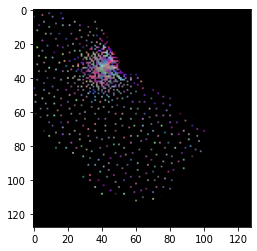

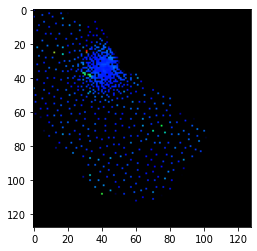

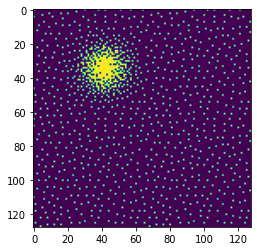

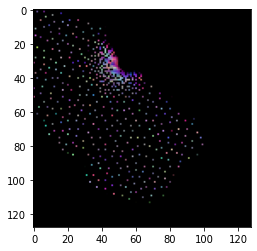

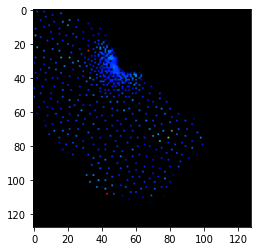

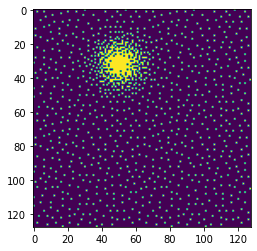

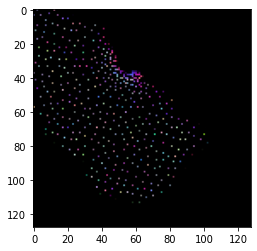

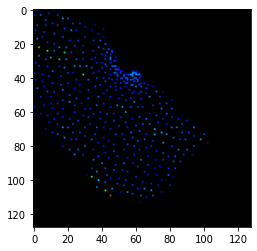

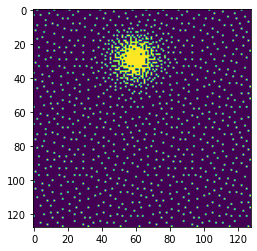

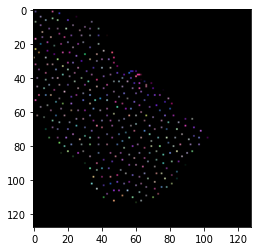

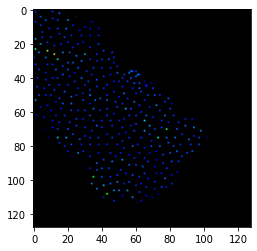

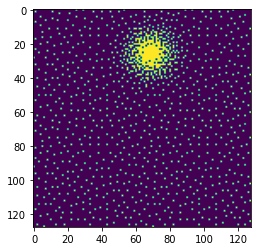

In [16]:
b = 1
for t in range(batch.shape[1]):
    img = image=np.transpose(batch[b,t,:,:,:], axes=[1,2,0])
    plt.imshow(img[:,:,3:6])
    plt.show()
    plt.imshow(img[:,:,:3])
    plt.show()
    plt.imshow(img[:,:,6])
    plt.show()

Testing the default augmentation setup

In [81]:
# transform = A.Compose([
#     A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ])

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=(-0.25,0.25), scale_limit=(-0.5,2.5), rotate_limit=(-45,45), border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Resize(128,128)
])

#transform = A.Compose([])

In [3]:
for b in range(batch.shape[0]):
    r = random.randint(0,sys.maxsize)
    for t in range(batch.shape[1]):
        random.seed(r)
        transformed = transform(image=np.transpose(batch[b,t,:,:,:], axes=[1,2,0]))
        #transformed = transform(image=batch[0,t,:,:,:])
        img = transformed['image']
        plt.imshow(img[:,:,3:6])
        plt.show()
        plt.imshow(img[:,:,:3])
        plt.show()
        plt.imshow(img[:,:,6])
        plt.show()

NameError: name 'batch' is not defined

### VGG19 Loss

In [8]:
import torchvision
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
        def __init__(self, cnn, feature_layers=[3, 8, 13, 22, 31]):
            super(FeatureExtractor, self).__init__()
            
            self.activation = []
            self.feature_layers = feature_layers
            self.cnn = cnn
            for feature_layer in self.feature_layers:
                self.cnn.features[feature_layer].register_forward_hook(self.get_activation(str(feature_layer)))
                
            #self.features = nn.Sequential(*list(cnn.features.children())[:(feature_layer + 1)])

        def get_activation(self, name):
            def hook(model, input, output):
                self.activation.append(output.detach())
            return hook
            
        def normalize(self, tensors, mean, std):
            if not torch.is_tensor(tensors):
                raise TypeError('tensor is not a torch image.')
            for tensor in tensors:
                for t, m, s in zip(tensor, mean, std):
                    t.sub_(m).div_(s)
            return tensors

        def forward(self, x):
            self.activation = []
            self.cnn(x)
            return self.activation

# Feature extracting using vgg19
if not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

device = torch.device("cuda:1")
MSE = nn.MSELoss().to(device)
vgg19 = torchvision.models.vgg19(pretrained=True)
feature_extractor = FeatureExtractor(vgg19).to(device)

class VGG19Loss(object):
    def __call__(self, output, target):

        output = feature_extractor(output)
        target = feature_extractor(target)
        
        loss = None
        for o, t in zip(output, target):
            if loss is None:
                loss = MSE(o,t)
                continue
            loss += MSE(o,t)
            
        return MSE(output[0], target[0]) + MSE(output[1], target[1])

In [12]:
criterion = VGG19Loss()

In [13]:
loss = criterion(batch[:,0,:,:,:].to(device), batch[:,9,:,:,:].to(device))

In [15]:
loss

tensor(1.2958, device='cuda:1')

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# Models and Summary
from models.DeepFoveaTorch import DeepFoveaNet
from torchsummary import summary
from tensorboardX import SummaryWriter

# Data
from util.dataloaders.ImageDataLoader import ImageDataLoader

# Losses
#from util.losses.pytorch.vgg19 import VGG19Loss

# Misc
import os
import datetime
from collections import defaultdict
from math import log10
import numpy as np
import matplotlib.pyplot as plt
from console_progressbar import ProgressBar

In [2]:
# Data
shape = (128,128)
batches = 2

# Network
in_channels = 7
out_channels = 3
features = [32, 64, 128, 128, 128]
depth = 5

device = 'cuda:1'

model = DeepFoveaNet(
        in_channels, out_channels,
        depth=depth, features=features
        )
#model.cuda()
model.to(device)
input_shape = (batches, in_channels, shape[0], shape[1])
temp_shapes = model.get_temporal_shapes(input_shape)  

In [3]:
temp_connection = model.get_initial_temporal_inputs(input_shape)

In [ ]:
traced_script_module = torch.jit.trace(model, (batch[:,0,:,:,:].to(device), temp_connection))

In [36]:
traced_script_module.save("traced_model.pt")

In [5]:
scripted_module = torch.jit.script(model)
scripted_module.save("scripted_model.pt")

In [6]:
!mv ./scripted_model.pt /media/data/checkpoints

In [17]:
!ls ./

checkpoints		 predict_VideoSequence.ipynb
data			 predict_VideoSequence-Pytorch.ipynb
imgaugtest.ipynb	 saved_model.pb
imggen_preprocess.ipynb  static_image_notebooks
model.png		 train_DeepFoveaRNN.ipynb
models			 train_Pytorch.ipynb
Pipfile			 util
Pipfile.lock		 video
playground.ipynb


# Fast Sparse Reprojection

In [97]:
import os
import math
import cv2
import matplotlib.pyplot as plt

import torch as torch
import torch.nn as nn
import torch.nn.functional as fun
import torchvision.transforms.functional as visfun

<ipython-input-146-b3b34f972f14>:5: RuntimeWarning: invalid value encountered in true_divide
  return cv2.GaussianBlur(frame0, (kernel_size, kernel_size), cv2.BORDER_DEFAULT) / np.expand_dims(cv2.GaussianBlur(frame1, (kernel_size, kernel_size), cv2.BORDER_DEFAULT), axis=2)


torch.Size([1, 256, 256, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


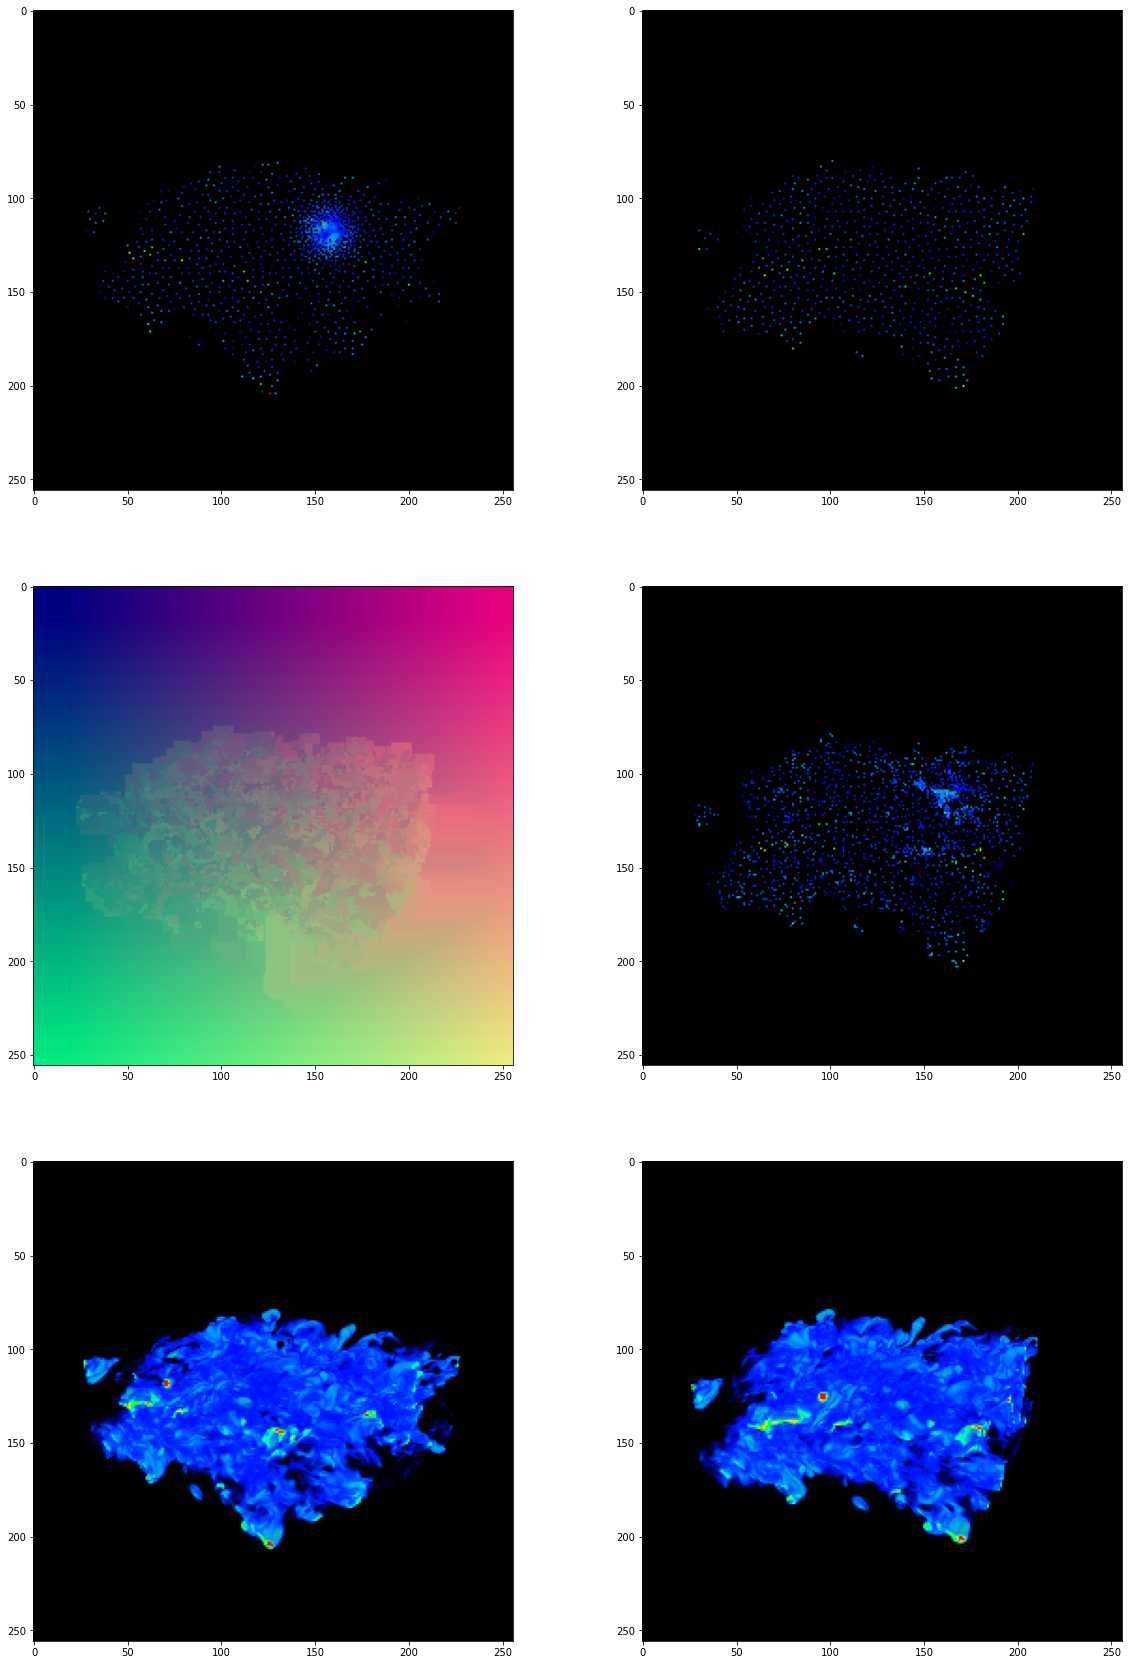

In [191]:
full_img_dir = './data/full'
img_dir = './data/masked_mid'
mask_dir = './data/masks_mid'
full_img_files = os.listdir(full_img_dir)
full_img_files.sort()
img_files = os.listdir(img_dir)
img_files.sort()
mask_files = os.listdir(mask_dir)
mask_files.sort()

#for file in os.listdir(img_dir)[-2:]:
#    image = cv2.imread(os.path.join(img_dir, file), cv2.IMREAD_COLOR)
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fid0 = 12
fid1 = 16

full0 = cv2.cvtColor(cv2.imread(os.path.join(full_img_dir, full_img_files[fid0]), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
frame0 = cv2.cvtColor(cv2.imread(os.path.join(img_dir, img_files[fid0]), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask0 = cv2.imread(os.path.join(mask_dir, mask_files[fid0]), cv2.IMREAD_GRAYSCALE)
full1 = cv2.cvtColor(cv2.imread(os.path.join(full_img_dir, full_img_files[fid1]), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(cv2.imread(os.path.join(img_dir, img_files[fid1]), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask1 = cv2.imread(os.path.join(mask_dir, mask_files[fid1]), cv2.IMREAD_GRAYSCALE)

output0 = image_to_tensor(_blur(frame0, mask0, kernel_size=7).astype(np.float32), True)
output1 = image_to_tensor(_blur(frame1, mask1, kernel_size=7).astype(np.float32), True)
mask0 = image_to_tensor(np.expand_dims((mask0/255).astype(np.float32), axis=2), True).permute(0,2,3,1)
print(mask0.size())

output, motion = reproject(output0, output1, kernel_size=35, return_motion=True)
output = fun.grid_sample(image_to_tensor((frame0/255).astype(np.float32), True), motion, align_corners=True)
output = tensor_to_image(output)

B, H, W, C = motion.size()
motion = torch.cat([motion, torch.zeros((B,H,W,1))], dim=3)
motion = (motion.squeeze(0).cpu().numpy() + 1.0) / 2

f, ax = plt.subplots(3,2, figsize=(20,30))
ax[0,0].imshow((frame0/255).astype(np.float32))
ax[0,1].imshow((frame1/255).astype(np.float32))
ax[1,0].imshow(motion)
ax[1,1].imshow(output+(frame1/255).astype(np.float32))
#ax[1,1].imshow(output)
ax[2,0].imshow((full0/255).astype(np.float32))
ax[2,1].imshow((full1/255).astype(np.float32))

In [146]:
def _blur(frame0, frame1, kernel_size=5):

    kernel = np.ones((kernel_size,kernel_size), np.uint8)

    return cv2.GaussianBlur(frame0, (kernel_size, kernel_size), cv2.BORDER_DEFAULT) / np.expand_dims(cv2.GaussianBlur(frame1, (kernel_size, kernel_size), cv2.BORDER_DEFAULT), axis=2)
    #return cv2.dilate(frame0, kernel), cv2.dilate(frame1, kernel)
    #return cv2.blur(frame0, (kernel_size, kernel_size)) / np.expand_dims(cv2.blur(frame1, (kernel_size, kernel_size)), axis=2)



In [180]:
# Non-Local Means Fast Reprojection 
# Reprojects frame I2 to I1
def hierarchical_reproject(I2, I1, depth = 4, kernel_size=5):

  # Downsample the input
  I1_scaled = [I1]
  I2_scaled = [I2]
  for _ in range(depth):
    I1_scaled.append(fun.interpolate(I1_scaled[-1], scale_factor=1/2, mode='bilinear'))
    I2_scaled.append(fun.interpolate(I2_scaled[-1], scale_factor=1/2, mode='bilinear'))

  # Upsample and apply reprojection in each level
  for d in range(depth-1,0,-1):
    motion = motion_kernel(I1_scaled[d], I2_scaled[d], kernel_size)
    motion = motion.permute((0,3,1,2))
    # TODO: If we upsample the motion map, we might introduce unwanted blurriness
    motion = fun.interpolate(motion, scale_factor=2, mode='bilinear', align_corners=False)
    motion = motion.permute((0,2,3,1))
    I2_scaled[d-1] = reproject(I2_scaled[d-1], motion)
  motion = motion_kernel(I1_scaled[0], I2_scaled[0], kernel_size)
  I2_scaled[0] = fun.grid_sample(I2_scaled[0], motion, align_corners=False)
  I2_scaled[0] = blend_kernel(I1, I2_scaled[0], a=0.8)

  # B,_,_,_ = I1.size()
  # for b in range(B):
  #   save_image(f'I1_{b}.png', tensor_to_image(I1[b]))
  #   save_image(f'I2_{b}.png', tensor_to_image(I2[b]))
  #   save_image(f'I_diff_{b}.png', tensor_to_image(torch.abs(I2_scaled[0][b] - I1[0])))
  #   save_image(f'I_diff_orig_{b}.png', tensor_to_image(torch.abs(I2[0] - I1[0])))

  #   for s in range(len(I1_scaled)):
  #     save_image(f'I1_re_{b}_{s}.png', tensor_to_image(I2_scaled[s][b]))

  return I2_scaled[0]

def reproject(I2, I1, kernel_size=15, return_motion=False):
  motion = motion_kernel(I1, I2, kernel_size)
  I = fun.grid_sample(I2, motion, align_corners=False)
  #I = blend_kernel(I1, I, a=0.95, k=2.5)

  # B,_,_,_ = I1.size()
  # for b in range(B):
  #   save_image(f'I1_{b}.png', tensor_to_image(I1[b, 0:3, ...]))
  #   save_image(f'I2_{b}.png', tensor_to_image(I2[b, 0:3, ...]))
  #   save_image(f'I_diff_{b}.png', tensor_to_image(torch.abs(I[b, 0:3, ...] - I1[b, 0:3, ...])))
  #   save_image(f'I_diff_orig_{b}.png', tensor_to_image(torch.abs(I2[b, 0:3, ...] - I1[b, 0:3, ...])))
  #   save_image(f'I1_re_{b}.png', tensor_to_image(I[b, 0:3, ...]))

  if return_motion:
    return I, motion
  else:
    return I

def motion_kernel(I1, I2, kernel_size):
  _, _, H, W = I1.size()
  x, S = distance_kernel(I1, I2, kernel_size, distance_function='L1')
  x = blur_kernel(x)
  x = merge_kernel(x, S, H, W)

  return x

# Calculate the distance between images at various levels of shift
# distance_function can take any value of ['L1', 'L2', 'logL1', 'logL1c']
def distance_kernel(I1, I2, kernel_size, distance_function='L1'):
  # Get device
  device = I1.device

  # Convert input images to grayscale
  I1 = visfun.rgb_to_grayscale(I1[:, 0:3, ...]).repeat((1, kernel_size**2, 1, 1))
  I2 = visfun.rgb_to_grayscale(I2[:, 0:3, ...]).repeat((1, kernel_size**2, 1, 1))

  # Create a search window grid S
  S = torch.arange(0, kernel_size, device=device).float()
  S_x, S_y = torch.meshgrid(S,S)
  S = torch.stack((S_y, S_x), dim=-1)
  S -= kernel_size // 2
  S = S.reshape(kernel_size**2, 2).flip(0)

  S_kernel = fun.one_hot(torch.arange(0, kernel_size**2, device=device)).unsqueeze(0).unsqueeze(0).reshape(kernel_size**2, 1, kernel_size, kernel_size).float()#.repeat(B,1,1,1)
  I2_shifted = fun.conv2d(input=I2, weight=S_kernel, stride=1, padding=kernel_size//2, groups=I2.size(1))

  if distance_function == 'L2':
    output = (I1 - I2_shifted) ** 2
  elif distance_function == 'L1':
    output = torch.abs(I1 - I2_shifted)
  elif distance_function == 'logL1':
    output = torch.log(2 + torch.abs(I1 - I2_shifted))
  # elif distance_function == 'logL1c':
  #   output = torch.log(2 + torch.abs(I1 - I2_shifted)) * (2 * torch.exp(-0.02*len_Sk**2))

  return output, S


def blur_kernel(I):
  blur_filter = get_gaussian_kernel(I.device, kernel_size=5, channels=I.size(1))
  out = blur_filter(I)
  return out
  #return visfun.gaussian_blur(I, kernel_size=5)

def get_gaussian_kernel(device, kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size, device=device)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=kernel_size//2)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

def merge_kernel(Is, S, input_height, input_width):

  # Get device
  device = Is.device

  # Create a map of relative offsets, each in [-1, 1]
  argmin_dist = torch.argmin(Is, dim=1)
  merged = S[argmin_dist]
  merged[..., 0] /= input_height/2
  merged[..., 1] /= input_width/2

  # Create base meshgrid
  grid_x, grid_y = torch.meshgrid(torch.linspace(-1,1,input_height, device=device), torch.linspace(-1,1,input_width, device=device))
  grid = torch.stack((grid_y, grid_x), dim=-1).unsqueeze(0).expand(-1, merged.size()[1], -1, -1)

  # Combine the mesh with offsets
  grid = grid - merged

  # Write debug image
  # merged = merged.permute((0,3,1,2))
  # B,_,H,W = merged.size()

  # for b in range(B):
  #   save_image(f'I_motion{b}_{input_width}.exr', tensor_to_image(torch.cat([0.5*(merged[b]+1.0), 0.5*torch.ones(1,H,W).to(merged.device)], dim=0)))

  return grid

In [102]:
# Converts a NumPy image to a tensor
def image_to_tensor(image, batch=False):
  # Reorder from HWC to CHW
  tensor = torch.from_numpy(image.transpose((2, 0, 1)))
  if batch:
    return tensor.unsqueeze(0) # reshape to NCHW
  else:
    return tensor

# Converts a tensor to a NumPy image
def tensor_to_image(image):
  if len(image.shape) == 4:
    # Remove N dimension
    image = image.squeeze(0)
  # Reorder from CHW to HWC
  return image.cpu().numpy().transpose((1, 2, 0))

## Random Noise like OVR

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from training.util_masks import *

ModuleNotFoundError: No module named 'tensorflow'

In [14]:
noise = np.random.uniform(0.0, 1.0, (64,64,1))
mask = np.zeros((64,64,1))
mask[noise<0.2] = 1

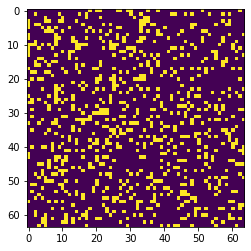

In [15]:
plt.imshow(mask)